In [16]:
#import libraries
import gpxpy
import gpxpy.gpx
import csv
import pandas as pd
import requests
import math
import uuid
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd

# define file locations to import and export
final_gpx_file_path = '/Users/nickstatz/Desktop/RAAM/RawDownloads/RAAM2024 GPS Exchange (final_5_31_24).gpx'
gpx_file_path = '/Users/nickstatz/Desktop/RAAM/RawDownloads/RAAM2024 GPS Exchange (final).gpx'

#exports
df_GPS_track_path = '/Users/nickstatz/Desktop/RAAM/df_GPS_track.csv'
segment_df_csv_path = '/Users/nickstatz/Desktop/RAAM/segments_reduced.csv'

In [17]:
# gpx to df 

# GPX file from RAAM GPS page https://40bdd70f-2135-4870-ab11-131a8a088964.filesusr.com/ugd/49fb96_2d5bd542879d4c809203ae55bd76e50f.gpx?dn=RAAM2024%20GPS%20Exchange%20(final).gpx
#gpx_file_path = '/Users/nickstatz/Desktop/RAAM/RawDownloads/RAAM2024 GPS Exchange (final).gpx'

# Open and parse the GPX file
with open(final_gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
    
#create empty list
points = []

# parse gpx file
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append((p.latitude,p.longitude,p.elevation,))

#write to df and csv
df = pd.DataFrame.from_records(points)
df_v2 = df.drop_duplicates()
dropped_dups = abs(len(df_v2)-len(df))
print("df1: ",len(df)," df_v2: ", len(df_v2)," Dropped rows: ",dropped_dups)

#df_GPS_track_path = '/Users/nickstatz/Desktop/RAAM/df_GPS_track.csv'
df_v2.to_csv(df_GPS_track_path)
points_v2 = list(df_v2.itertuples(index=False, name=None))
print("v1: ", len(points), " v2: ",len(points_v2))

df1:  47742  df_v2:  47705  Dropped rows:  37
v1:  47742  v2:  47705


In [18]:
# create segments - from Steve W.
segments = []

# first segment
segment={}
segment['begin'] = {}
segment['begin']['latitude'] = points_v2[0][0]
segment['begin']['longitude'] = points_v2[0][1]
segment['begin']['elev']=points_v2[0][2]
segment['begin']['id'] = uuid.uuid4()
segment['end'] = {}
segment['end']['latitude'] = points_v2[2][0]
segment['end']['longitude'] = points_v2[2][1]
segment['end']['elev']=points_v2[2][2]
segment['end']['id'] = uuid.uuid4()
segments.append(segment)

# remaining segments iterate over every other to reduce # segments
for i in range(2, len(points_v2)-1,2):
    segment={}
    segment['begin'] = {}
    segment['begin']['latitude'] = points_v2[i][0]
    segment['begin']['longitude'] = points_v2[i][1]
    segment['begin']['elev']=points_v2[i][2]
    segment['begin']['id'] = segments[-1]['end']['id']
    segment['end'] = {}
    segment['end']['latitude'] = points_v2[i+2][0]
    segment['end']['longitude'] = points_v2[i+2][1]
    segment['end']['elev']=points_v2[i+2][2]
    segment['end']['id'] = uuid.uuid4()
    segments.append(segment)
    
len(segments)

23852

In [19]:
# get distance of each seg - originally tried using OSRM open API but error in total distance was significant

def distance_in_m(lat1,lon1,lat2,lon2):
    # haversine function coords must be in radians
    lat_1 = math.radians(lat1)
    lat_2 = math.radians(lat2)
    lon_1 = math.radians(lon1)
    lon_2 = math.radians(lon2)
    change_lat = lat_2-lat_1
    change_lon = lon_2-lon_1
    a=math.sqrt((math.sin(change_lat/2))**2+math.cos(lat_1)*math.cos(lat_2)*(math.sin(change_lon/2))**2)
    d=2*6371000*math.asin(a)
    return d

for seg in segments:
    seg['dist_m'] = distance_in_m(seg['begin']['latitude'],seg['begin']['longitude'],seg['end']['latitude'],seg['end']['longitude'])
segments

[{'begin': {'latitude': 33.19445600733161,
   'longitude': -117.38425802439451,
   'elev': 0.0,
   'id': UUID('fd495fec-b251-4a5d-8e73-032c361fd39d')},
  'end': {'latitude': 33.19688198156655,
   'longitude': -117.3863030411303,
   'elev': 0.0,
   'id': UUID('8eb13133-cc32-4b99-96fa-d06d5e55cbde')},
  'dist_m': 330.1166683347081},
 {'begin': {'latitude': 33.19688198156655,
   'longitude': -117.3863030411303,
   'elev': 0.0,
   'id': UUID('8eb13133-cc32-4b99-96fa-d06d5e55cbde')},
  'end': {'latitude': 33.19789602421224,
   'longitude': -117.3847440071404,
   'elev': 14.1,
   'id': UUID('6c780dd0-9322-4e41-9683-43e44f1dd28b')},
  'dist_m': 183.7315415370453},
 {'begin': {'latitude': 33.19789602421224,
   'longitude': -117.3847440071404,
   'elev': 14.1,
   'id': UUID('6c780dd0-9322-4e41-9683-43e44f1dd28b')},
  'end': {'latitude': 33.19833196699619,
   'longitude': -117.38407999277115,
   'elev': 14.8,
   'id': UUID('f9b7d213-89c7-4a57-9ca0-66e6f07732e6')},
  'dist_m': 78.53046066475694},

In [20]:
smalls = 0
totaldist = 0
for seg in segments:
    if seg['dist_m'] < 50: smalls+=1
    totaldist += seg['dist_m']

In [21]:
totaldist/1000

4925.823581928343

In [22]:
smalls

5879

In [23]:
len(segments)

23852

In [24]:
#Updated bearing calculation - was getting results inconsistent with expected
def calculate_bearing(segment):
    """
    Calculate the bearing between two points. From https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/
    
    Parameters:
    segment from track to calculate bearing of
    
    Returns:
    Bearing in degrees from the 'from' point to the 'end' point
    
    All the angles are measured w.r.t North Direction
    Angles measured clockwise are +ve and anti-clockwise are -ve
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(segment['begin']['latitude'])
    lon1 = math.radians(segment['begin']['longitude'])
    lat2 = math.radians(segment['end']['latitude'])
    lon2 = math.radians(segment['end']['longitude'])

    # Calculate the differences
    delta_lon = lon2 - lon1
    
    # Calculate the components of the bearing
    y = (math.cos(lat1) * math.sin(lat2)) - (math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon))
    x = math.cos(lat2) * math.sin(delta_lon)
    
    # Calculate the bearing
    beta = math.atan2(x,y)
    
    # Convert the bearing from radians to degrees
    degrees = math.degrees(beta)
    compass = (degrees +360)%360
    return beta

for seg in segments:
    seg['bearing'] = calculate_bearing(seg)
#segments

In [25]:
# determine slope of each segment
for seg in segments:
    if seg['dist_m'] != 0:
        seg['slope'] = (seg['end']['elev']-seg['begin']['elev'])/seg['dist_m']
segments

[{'begin': {'latitude': 33.19445600733161,
   'longitude': -117.38425802439451,
   'elev': 0.0,
   'id': UUID('fd495fec-b251-4a5d-8e73-032c361fd39d')},
  'end': {'latitude': 33.19688198156655,
   'longitude': -117.3863030411303,
   'elev': 0.0,
   'id': UUID('8eb13133-cc32-4b99-96fa-d06d5e55cbde')},
  'dist_m': 330.1166683347081,
  'bearing': -0.6143310136952571,
  'slope': 0.0},
 {'begin': {'latitude': 33.19688198156655,
   'longitude': -117.3863030411303,
   'elev': 0.0,
   'id': UUID('8eb13133-cc32-4b99-96fa-d06d5e55cbde')},
  'end': {'latitude': 33.19789602421224,
   'longitude': -117.3847440071404,
   'elev': 14.1,
   'id': UUID('6c780dd0-9322-4e41-9683-43e44f1dd28b')},
  'dist_m': 183.7315415370453,
  'bearing': 0.9100480801314998,
  'slope': 0.07674240297579528},
 {'begin': {'latitude': 33.19789602421224,
   'longitude': -117.3847440071404,
   'elev': 14.1,
   'id': UUID('6c780dd0-9322-4e41-9683-43e44f1dd28b')},
  'end': {'latitude': 33.19833196699619,
   'longitude': -117.38407

In [26]:
# calculate cumulative distance to beginning of segment
total_dist = 0
for seg in segments:
    seg['cumulative_distance_to_segment'] = total_dist
    total_dist += seg['dist_m']
#segments

In [27]:
# assign unique id to each segment
for segment in segments:
    segment['seg_id'] = str(uuid.uuid4())

In [28]:
def create_segment_df(segments):

    rows = []

    for seg in segments:
        rows.append({
                        'from_lat': seg['begin']['latitude'], 
                        'from_lon': seg['begin']['longitude'], 
                        'from_elevation': seg['begin']['elev'] if 'elev' in segment['begin'].keys() else "",
                        'to_lat': seg['end']['latitude'], 
                        'to_lon': seg['end']['longitude'], 
                        'to_elevation': seg['end']['elev'] if 'elev' in segment['end'].keys() else "",
                        'length_m': seg['dist_m'], 
                        'bearing': seg['bearing'], 
                        'slope': seg['slope'] if 'slope' in segment.keys() else None,
                        'segment_id': seg['seg_id'],
                        'cumulative_distance_to_segment': seg['cumulative_distance_to_segment']
                    }) 

        df = pd.DataFrame(rows)

    return df

In [29]:
segment_df = create_segment_df(segments)
segment_df

,from_lat,from_lon,from_elevation,to_lat,to_lon,to_elevation,length_m,bearing,slope,segment_id,cumulative_distance_to_segment
0,33.194456,-117.384258,0.0,33.196882,-117.386303,0.0,330.116668,-0.614331,0.000000,3deb05b4-5f1d-465b-bf0d-d766c5f1f0ac,0.000000e+00
1,33.196882,-117.386303,0.0,33.197896,-117.384744,14.1,183.731542,0.910048,0.076742,62f6deea-c0ca-4365-b90e-0637b9a2a5c0,3.301167e+02
2,33.197896,-117.384744,14.1,33.198332,-117.384080,14.8,78.530461,0.905523,0.008914,ffcfd8df-6e06-4efd-b5a3-c9870dca0807,5.138482e+02
3,33.198332,-117.384080,14.8,33.198492,-117.384010,14.9,18.946670,0.350864,0.005278,fedeb490-45da-4953-a470-eea4c97ad132,5.923787e+02
4,33.198492,-117.384010,14.9,33.199950,-117.385227,14.1,197.753325,-0.609662,-0.004045,da390fb7-df49-4d58-954d-50ad82a8a4e4,6.113253e+02
...,...,...,...,...,...,...,...,...,...,...,...
23847,39.349509,-74.451258,1.7,39.350372,-74.448823,1.6,230.313842,1.141021,-0.000434,44a53d2b-2f1f-440f-bcff-0bad783e23f8,4.924565e+06
23848,39.350372,-74.448823,1.6,39.351230,-74.446351,1.5,232.988177,1.148908,-0.000429,46a49963-f752-4eb7-8f9a-c7feffbf7965,4.924796e+06
23849,39.351230,-74.446351,1.5,39.352014,-74.443985,1.5,221.324002,1.165948,0.000000,dc91ded0-8258-40ec-aa5d-4d48bd11ad21,4.925029e+06
23850,39.352014,-74.443985,1.5,39.353076,-74.440594,1.3,314.570959,1.185957,-0.000636,ece7a002-f557-4c67-a483-c15cfdb53d41,4.925250e+06


In [30]:
segment_df_csv_path = '/Users/nickstatz/Desktop/RAAM/segments_reduced.csv'
segment_df.to_csv(segment_df_csv_path,index = False)

In [31]:
# export segments as pickle
import pickle

# df to pkl
segment_df.to_pickle('segment_df_reduced.pkl')


# list of dicts to pkl
f = open('segments_reduced.pkl', "wb")
pickle.dump(segments, f)
f.close()

trythis = pickle.load( open( 'segments_reduced.pkl', 'rb' ) )
trythis_df = pickle.load( open( 'segment_df_reduced.pkl', 'rb' ) )

trythis_df

,from_lat,from_lon,from_elevation,to_lat,to_lon,to_elevation,length_m,bearing,slope,segment_id,cumulative_distance_to_segment
0,33.194456,-117.384258,0.0,33.196882,-117.386303,0.0,330.116668,-0.614331,0.000000,3deb05b4-5f1d-465b-bf0d-d766c5f1f0ac,0.000000e+00
1,33.196882,-117.386303,0.0,33.197896,-117.384744,14.1,183.731542,0.910048,0.076742,62f6deea-c0ca-4365-b90e-0637b9a2a5c0,3.301167e+02
2,33.197896,-117.384744,14.1,33.198332,-117.384080,14.8,78.530461,0.905523,0.008914,ffcfd8df-6e06-4efd-b5a3-c9870dca0807,5.138482e+02
3,33.198332,-117.384080,14.8,33.198492,-117.384010,14.9,18.946670,0.350864,0.005278,fedeb490-45da-4953-a470-eea4c97ad132,5.923787e+02
4,33.198492,-117.384010,14.9,33.199950,-117.385227,14.1,197.753325,-0.609662,-0.004045,da390fb7-df49-4d58-954d-50ad82a8a4e4,6.113253e+02
...,...,...,...,...,...,...,...,...,...,...,...
23847,39.349509,-74.451258,1.7,39.350372,-74.448823,1.6,230.313842,1.141021,-0.000434,44a53d2b-2f1f-440f-bcff-0bad783e23f8,4.924565e+06
23848,39.350372,-74.448823,1.6,39.351230,-74.446351,1.5,232.988177,1.148908,-0.000429,46a49963-f752-4eb7-8f9a-c7feffbf7965,4.924796e+06
23849,39.351230,-74.446351,1.5,39.352014,-74.443985,1.5,221.324002,1.165948,0.000000,dc91ded0-8258-40ec-aa5d-4d48bd11ad21,4.925029e+06
23850,39.352014,-74.443985,1.5,39.353076,-74.440594,1.3,314.570959,1.185957,-0.000636,ece7a002-f557-4c67-a483-c15cfdb53d41,4.925250e+06


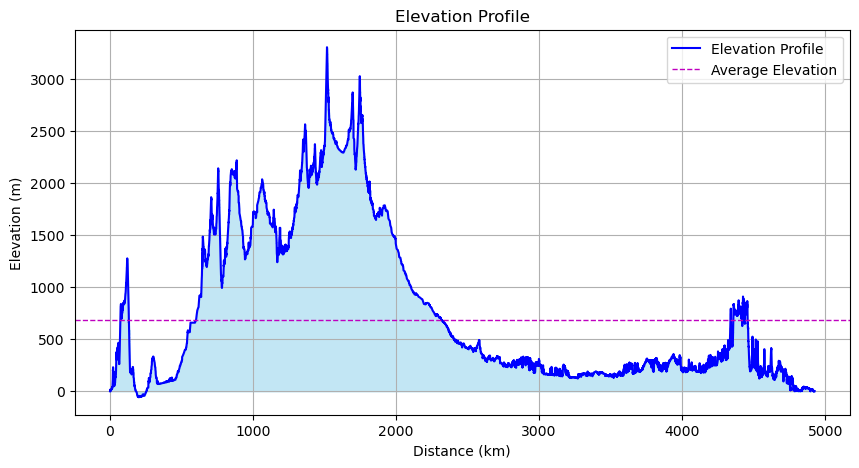

In [32]:
#Create Elevation Plot

distances = segment_df['cumulative_distance_to_segment'].to_list()
elevations = segment_df['to_elevation'].to_list()
distances_km = [d / 1000 for d in distances]
average_elevation = sum(elevations) / len(elevations)

#PLOT ELEVATION PROFILE
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(distances_km, elevations, linestyle='-', color='b', linewidth=1.5, label='Elevation Profile')

# Plot the average elevation line
plt.axhline(y=average_elevation, color='m', linestyle='--', linewidth=1, label='Average Elevation')

# Customize the plot
plt.title('Elevation Profile')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.grid(True)
plt.legend()  # Add a legend to differentiate the lines
plt.fill_between(distances_km, elevations, color='skyblue', alpha=0.5)

# Display the plot
plt.savefig('elevation_profile_map_reduced.png', dpi=300)
plt.show()

/var/folders/rd/q0cb2t154gl8yv342sm8kzsh0000gn/T/ipykernel_26675/3534595974.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


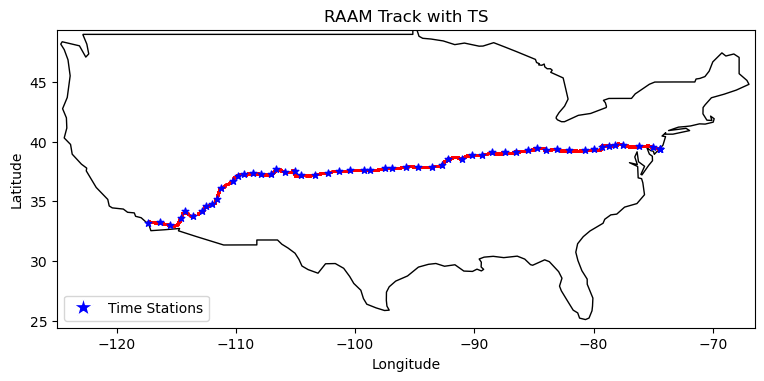

In [33]:
import geopandas as gpd


# downloadable from RAAM GPS Info page: https://www.raamrace.org/_files/ugd/49fb96_42d3e9a89c2841d9b955857c94f9bc33.csv?dn=RAAM2024%20Time%20Stations%20(final).csv
timeStationPath = '/Users/nickstatz/Desktop/RAAM/RawDownloads/RAAM2024 Time Stations (final) copy.csv'
ts_coords = pd.read_csv(timeStationPath)

# Create a GeoDataFrame
try:
    gdf = gpd.GeoDataFrame(
        segment_df, geometry=gpd.points_from_xy(segment_df.from_lon, segment_df.from_lat))
except Exception as e:
    print(f"Error creating GeoDataFrame: {e}")

# Load a map of the United States
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = world[(world.name == "United States of America")]

# Plot the US map
ax = us.plot(figsize=(9, 6), color='white', edgecolor='black')

# Plot the points on the map
gdf.plot(ax=ax, color='red', markersize=1)

# Set x and y limits to focus on the US
ax.set_xlim([-125, -66.5])  # Longitude range
ax.set_ylim([24.396308, 49.384358])  # Latitude range

# Add title and labels
ax.set_title('RAAM Track with TS')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

for idx, row in ts_coords.iterrows():
    ax.scatter(row['Longitude'], row['Latitude-N'], marker = '*',label = row['Name'], color='blue', s=25)
    
# Create a custom legend
custom_markers = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=15, label='Time Stations')
]

# Add the custom legend
ax.legend(handles=custom_markers, loc='lower left')

# Save the plot to a file
plt.savefig('RAAM_Track_reduced.png', dpi=300)

# Display the plot
plt.show()
